# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline 
import numpy as np
from glob import glob
from tqdm import tqdm
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import os as os

from torchvision import datasets

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

In [35]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))
dog_classes = np.array(glob("/data/dog_images/*/*"))

#define the image path for train, valid, test
train_dir = np.array(glob("/data/dog_images/*/"))[0]
test_dir = np.array(glob("/data/dog_images/*/"))[1]
valid_dir = np.array(glob("/data/dog_images/*/"))[2]

train_images = np.array(glob("/data/dog_images/train/*/*"))
test_images = np.array(glob("/data/dog_images/test/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))
print('There are %d total of my images.'% len(my_images))

There are 13233 total human images.
There are 8351 total dog images.
There are 0 total of my images.


In [4]:
#define the files that are input to the run_app
human_files_4 = (human_files[1], human_files[45], human_files[137], human_files[235])
human_files_4
dog_files_4 = (dog_files[765], dog_files[80], dog_files[137], dog_files[243])
dog_files_4

('/data/dog_images/train/108.Norwegian_buhund/Norwegian_buhund_07122.jpg',
 '/data/dog_images/train/059.Doberman_pinscher/Doberman_pinscher_04199.jpg',
 '/data/dog_images/train/055.Curly-coated_retriever/Curly-coated_retriever_03898.jpg',
 '/data/dog_images/train/024.Bichon_frise/Bichon_frise_01771.jpg')

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


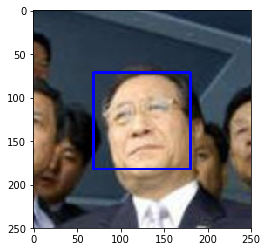

In [5]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[7])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__
(You can print out your results and/or write your percentages in this cell)
Correct human face detections: 98.00
Correct dog face detections: 17.00

In [8]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

In [9]:
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
num_correct_h = 0
num_correct_d = 0

#test the number of correct human face detections
for files in human_files_short:
    if face_detector(files):
        num_correct_h += 1
percent_correct_h = (num_correct_h/len(human_files_short))*100

#test the number of correct dog face detections
for files in dog_files_short:
    if face_detector(files):
        num_correct_d += 1
percent_correct_d = (num_correct_d/len(dog_files_short))*100
#
#print the results
print('Correct human face detections: {:.2f}'.format(percent_correct_h))
print('Correct dog face detections: {:.2f}'.format(percent_correct_d))

Correct human face detections: 98.00
Correct dog face detections: 17.00


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [7]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [10]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:07<00:00, 75024737.05it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [11]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    Args:
        img_path: path to an image
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    # define training and test data directories
    
    # pre process then predict
    img = Image.open(img_path).convert('RGB')
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         normalize])
    img = transform(img).unsqueeze(0)
    if use_cuda:
        img = img.cuda()
    output = VGG16(img)
    top_prob = torch.max(output,1)
    predicted_class = top_prob[1].item()
    
    return predicted_class

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    predicted_class = VGG16_predict(img_path)
    return predicted_class > 150 and predicted_class < 269   #true or false conditions

In [15]:
#VGG16_predict(dog_files_short[0])
print(dog_detector(dog_files_short[0]), dog_detector(human_files_short[0]))

True False


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [16]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
detected_dogs_h = 0
for file in human_files_short:
    if dog_detector(file):
        detected_dogs_h += 1
p_humanfile_dogs = (detected_dogs_h/len(human_files_short))*100       
print("Percentage of detected dogs in human files short is:  {:.2f}%".format(p_humanfile_dogs))

detected_dogs_d = 0
for file in dog_files_short:
    if dog_detector(file):
        detected_dogs_d += 1
p_dogfile_dogs = (detected_dogs_d/len(dog_files_short))*100
print("Percentage of detected dogs in dog files short is:  {:.2f}%".format(p_dogfile_dogs))

Percentage of detected dogs in human files short is:  0.00%
Percentage of detected dogs in dog files short is:  100.00%


__Answer:__
Percentage of detected dogs in human files short is:  0.00%
Percentage of detected dogs in dog files short is:  100.00%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [17]:
#Dataloaders for use with VGG16 transfer network or other
batch_size = 20
num_workers = 0

### TODO: Write data loaders for training, validation, and test sets
# VGG-16 Takes 224x224 images as input, custom CNN input same size so easy to compare.  
# since training, need to augment with random horizontal flip to improve performance
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
data_transform = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor()]),
                  'valid': transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor()]),
                  'test' : transforms.Compose([transforms.Resize(size=(224,224)),
                                               transforms.ToTensor()])}

train_data = datasets.ImageFolder(train_dir, transform=data_transform['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform['valid'])
test_data = datasets.ImageFolder(test_dir, transform=data_transform['test'])

#define all three data loaders
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size, 
                                          num_workers=num_workers,
                                          shuffle=False)

#need these scratch loaders for testing my CNN model
loaders_scratch = {'train': train_loader,'valid': valid_loader,'test': test_loader}

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))


Num training images:  6680
Num test images:  836


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
I picked an input tensor of size 224 x 224 partly because that is what I'm used to but also I read that this is the minimum size for VGG16 image input.  For train data I resize to 224, random, and random horizontal flip to augment the data with this randomness to limit overfitting and improve the training.  For Validation data I resized to 256 then centercrop the images to 224x224.  Since there is no learning, no need to have augmented data.  Similarly for test data I only resized images to 224x224 as I said because that is accepted by VGG16.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [12]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.Conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)     
        self.Conv2 = nn.Conv2d(32, 64, 3, padding=1)   
        self.Conv3 = nn.Conv2d(64, 128, 3, padding=1)  
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(25088,5000)
        self.fc2 = nn.Linear(5000,133)  #number of dog breed classes
        
        self.dropout = nn.Dropout(0.3)
     
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.Conv1(x))   #output size = 32x112x112
        x = self.pool(x)
        x = F.relu(self.Conv2(x))   #output size = 64x56x56
        x = self.pool(x)       
        x = F.relu(self.Conv3(x))   #output size = 128x28x28
        x = self.pool(x)            #128x14x14
        
        #flatten
        x = x.view(-1,25088)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [139]:
#test out model
model_scratch.fc1.type


<bound method Module.type of Linear(in_features=25088, out_features=5000, bias=True)>

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
I looked at vgg16 to utilize similar layers.  That drove me to Conv2d, Maxpool.  Since there are only dog images to process I thought the problem space was smaller for my network than what vgg16 is used to do.  So overall I thought my network could be much smaller....less deep. I wanted to actually use more convolutional layers than I have (3) because I konw that the early conv layers detect things like lines, edges etc.  So to get to the fine detail we need to differentiate similar dog/breeds I would need 3 or more layers.  But I needed to add maxpooling layers to downsample each conv output since the depth meant they'd be large tensors.  I used 2 fully connected layers of type nn.Linear to train the classifier and next time I probably would have added one more linear layer but my training met the rubric requirement.  I uesd the dropout to mange overfitting.  I hadn't achieved the required >10% accuracy in my training pass I was planning to add ColorJitter and augment with changes in contrast and brightness

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [13]:
# Loss and optimizer for use with VGG16 transfer network
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [14]:
#train the VGG16 modified model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            #target = target.type(torch.LongTensor)
            #data = data.type(torch.LongTensor)
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()   #initialize weights to zero
            output = model(data)    #run model and return class probabilities
            
            loss = criterion(output, target)   #compute output loss
            loss.backward()         #back propogate
            optimizer.step()        #apply gradients
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.4f' % (epoch, batch_idx+1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            #no backprop since not training
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print("Validation loss decreased. Saving model... ({:.4f} --<-- {:.4f})".format(
                   valid_loss, valid_loss_min))
            valid_loss_min = valid_loss #establish new minimum
            
            
    # return trained model
    return model


# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')


Epoch 1, Batch 1 loss: 4.8926
Epoch 1, Batch 101 loss: 4.8837
Epoch: 1 	Training Loss: 4.883227 	Validation Loss: 4.885929
Validation loss decreased. Saving model... (4.8859 --<-- inf)
Epoch 2, Batch 1 loss: 4.8444
Epoch 2, Batch 101 loss: 4.8718
Epoch: 2 	Training Loss: 4.872156 	Validation Loss: 4.884972
Validation loss decreased. Saving model... (4.8850 --<-- 4.8859)
Epoch 3, Batch 1 loss: 4.8683
Epoch 3, Batch 101 loss: 4.8624
Epoch: 3 	Training Loss: 4.861798 	Validation Loss: 4.887898
Epoch 4, Batch 1 loss: 4.8479
Epoch 4, Batch 101 loss: 4.8474
Epoch: 4 	Training Loss: 4.847921 	Validation Loss: 4.856307
Validation loss decreased. Saving model... (4.8563 --<-- 4.8850)
Epoch 5, Batch 1 loss: 4.7625
Epoch 5, Batch 101 loss: 4.7960
Epoch: 5 	Training Loss: 4.794421 	Validation Loss: 4.796093
Validation loss decreased. Saving model... (4.7961 --<-- 4.8563)
Epoch 6, Batch 1 loss: 4.8199
Epoch 6, Batch 101 loss: 4.7141
Epoch: 6 	Training Loss: 4.713262 	Validation Loss: 4.628420
Valid

KeyboardInterrupt: 

In [15]:
# load the model that got the best validation accuracy
#model_scratch.load_state_dict(torch.load('model_scratch.pt'))

# load the version of the Resnet50 modified model with trained classifier that got the best validation accuracy
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
model_scratch.load_state_dict(torch.load('model_scratch.pt', map_location=map_location))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [16]:
#General test the model code for returning accuracy
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [17]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.064363


Test Accuracy: 12% (107/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [18]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [23]:
## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)
# check if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:06<00:00, 14958895.00it/s]


In [24]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [25]:
#do not train feature portion of resnet
for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.fc = nn.Linear(2048, 133, bias=True)
fc_params = model_transfer.fc.parameters()

#train my classifier portion of modified resnet
for param in fc_params:
    param.requires_grad = True

In [26]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
I chose Resnet since it is newer than vgg, and has a lower error rate
fc layer input requires size of 2048 and has output layer of 1000.  But for dog breeds, there are only 133 classifications so my output features will need to be 133.  I set bias=true since that is the setting used by Resnet

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [23]:
#Loss function and optimizers defined for my custom CNN model
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [29]:
if use_cuda:
    model_transfer = model_transfer.cuda()

In [37]:
#Train the Resnet classifier model I created
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            #target = target.type(torch.LongTensor)
            #data = data.type(torch.LongTensor)
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()   #initialize weights to zero
            output = model(data)    #run model and return class probabilities
            
            loss = criterion(output, target)   #compute output loss
            loss.backward()         #back propogate
            optimizer.step()        #apply gradients
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.4f' % (epoch, batch_idx+1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            #no backprop since not training
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print("Validation loss decreased. Saving model... ({:.4f} --<-- {:.4f})".format(
                   valid_loss, valid_loss_min))
            valid_loss_min = valid_loss #establish new minimum
            
            
    # return trained model
    return model

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [67]:
# train the Resnet50 model with custom classifier
model_transfer = train(100, loaders_transfer, model_transfer, optimizer_transfer, 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch 1, Batch 1 loss: 4.8936
Epoch 1, Batch 101 loss: 4.0015
Epoch 1, Batch 201 loss: 3.2915
Epoch 1, Batch 301 loss: 2.8693
Epoch: 1 	Training Loss: 2.756522 	Validation Loss: 1.009421
Validation loss decreased. Saving model... (1.0094 --<-- inf)
Epoch 2, Batch 1 loss: 1.6219
Epoch 2, Batch 101 loss: 1.5486
Epoch 2, Batch 201 loss: 1.4501
Epoch 2, Batch 301 loss: 1.3902
Epoch: 2 	Training Loss: 1.373348 	Validation Loss: 0.698845
Validation loss decreased. Saving model... (0.6988 --<-- 1.0094)
Epoch 3, Batch 1 loss: 1.0835
Epoch 3, Batch 101 loss: 1.1547
Epoch 3, Batch 201 loss: 1.1639
Epoch 3, Batch 301 loss: 1.1333
Epoch: 3 	Training Loss: 1.133240 	Validation Loss: 0.595122
Validation loss decreased. Saving model... (0.5951 --<-- 0.6988)
Epoch 4, Batch 1 loss: 0.7781
Epoch 4, Batch 101 loss: 1.0068
Epoch 4, Batch 201 loss: 1.0113
Epoch 4, Batch 301 loss: 1.0159
Epoch: 4 	Training Loss: 1.020357 	Validation Loss: 0.503756
Validation loss decreased. Saving model... (0.5038 --<-- 0.5

KeyboardInterrupt: 

In [24]:
# load the version of the Resnet50 modified model with trained classifier that got the best validation accuracy
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=map_location))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [99]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.506040


Test Accuracy: 84% (705/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [19]:
#Predict dog breed with the modified Resnet50 model
batch_size = 20
num_workers = 0

### TODO: Write data loaders for training, validation, and test sets
# VGG-16 Takes 224x224 images as input, custom CNN input same size so easy to compare.  
# since training, need to augment with random horizontal flip to improve performance
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
data_transform = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor()]),
                  'valid': transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor()]),
                  'test' : transforms.Compose([transforms.Resize(size=(224,224)),
                                               transforms.ToTensor()])}

train_data = datasets.ImageFolder(train_dir, transform=data_transform['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform['valid'])
test_data = datasets.ImageFolder(test_dir, transform=data_transform['test'])

#define all three data loaders
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size, 
                                          num_workers=num_workers,
                                          shuffle=False)

#need these scratch loaders for testing my CNN model
loaders_scratch = {'train': train_loader,'valid': valid_loader,'test': test_loader}
loaders_transfer = loaders_scratch

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  6680
Num test images:  836


In [20]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]
class_names[:30]


['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog',
 'Australian cattle dog',
 'Australian shepherd',
 'Australian terrier',
 'Basenji',
 'Basset hound',
 'Beagle',
 'Bearded collie',
 'Beauceron',
 'Bedlington terrier',
 'Belgian malinois',
 'Belgian sheepdog',
 'Belgian tervuren',
 'Bernese mountain dog',
 'Bichon frise',
 'Black and tan coonhound',
 'Black russian terrier',
 'Bloodhound',
 'Bluetick coonhound',
 'Border collie',
 'Border terrier']

In [21]:
def load_image(img_path):
    # pre process then predict
    img = Image.open(img_path).convert('RGB')
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    normalize])
    img = transform(img).unsqueeze(0)
    if use_cuda:
        img = img.cuda()
    
    return img   

In [27]:
# load the model that got the best validation accuracy
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=map_location))

In [28]:
def predict_breed_transfer(model, img_path):
    # load the image and return the predicted breed
    # load the model that got the best validation accuracy
        
    img = load_image(img_path)
    #use cuda if available
    if use_cuda:
        model = model.cuda()
    model.eval()
    output = model(img)
    idx, pred = torch.max(output,1)
    return class_names[pred]

In [29]:
#This is a test cell so I can figure out why the prediction is usually German Pinscher
for idx, file in enumerate(test_images[75:145]):
    img_path = test_images[idx]
    prediction = predict_breed_transfer(model_transfer,img_path)
    print(test_images[idx], "\t  Predicted breed: {0}".format(prediction))

/data/dog_images/test/103.Mastiff/Mastiff_06873.jpg 	  Predicted breed: Golden retriever
/data/dog_images/test/103.Mastiff/Mastiff_06815.jpg 	  Predicted breed: Chow chow
/data/dog_images/test/103.Mastiff/Mastiff_06878.jpg 	  Predicted breed: German pinscher
/data/dog_images/test/103.Mastiff/Mastiff_06825.jpg 	  Predicted breed: German pinscher
/data/dog_images/test/103.Mastiff/Mastiff_06836.jpg 	  Predicted breed: Chow chow
/data/dog_images/test/103.Mastiff/Mastiff_06847.jpg 	  Predicted breed: Golden retriever
/data/dog_images/test/103.Mastiff/Mastiff_06827.jpg 	  Predicted breed: German pinscher
/data/dog_images/test/059.Doberman_pinscher/Doberman_pinscher_04190.jpg 	  Predicted breed: German pinscher
/data/dog_images/test/059.Doberman_pinscher/Doberman_pinscher_04194.jpg 	  Predicted breed: German pinscher
/data/dog_images/test/059.Doberman_pinscher/Doberman_pinscher_04156.jpg 	  Predicted breed: German pinscher
/data/dog_images/test/059.Doberman_pinscher/Doberman_pinscher_04177.jp

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [30]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    #plot the image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    if dog_detector(img_path):
        predicted_breed = predict_breed_transfer(model_transfer, img_path)
        print("The predicted breed is...{0}".format(predicted_breed))
    elif face_detector(img_path) > 0:
        predicted_breed = predict_breed_transfer(model_transfer, img_path)
        print("Hello human!  You most closely resemble a ... {0}".format(predicted_breed))
    else:
        print("The dog detector did not predict a breed")


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
The output is way worse than I expected.  However the human face and dog detectors were pretty darn accurate, the breed predictor was in my opinion pretty bad.  After getting so many incorrect predictions on dog breed for dogs I reran the udacity test function on the model_transfer to see if something changed since loading the model from my computer using model_transfer.pt.  But I still got 84% accuracy.  However in looking manually at the predictions it is heavily skewed towards picking german pinscher, same for human faces and I want to understand why. 
Three points of improvement:  1) I would randomize the text images so they are not all grouped into same breed class...just to make it easier for me to grab a test set wtih different breeds and more easily see if it is predicting correctly.  2) I would spend some writing code to compare each prediction to the target 3) I would modify my dataloader for train so I do a bit more augmentation and use ColorJitter among several other options.  4) I would introduce more layers into model_transfer layer and try to train it better, and for longer.

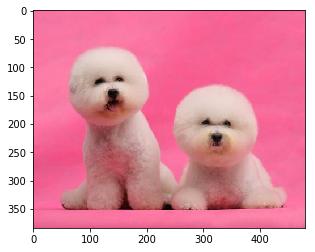

The predicted breed is...Cavalier king charles spaniel


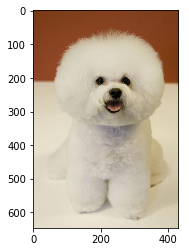

The predicted breed is...Giant schnauzer


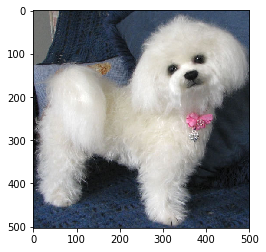

The predicted breed is...German pinscher


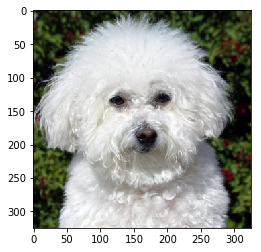

The predicted breed is...Chow chow


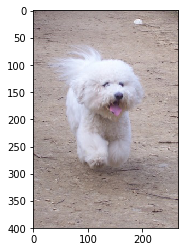

The predicted breed is...French bulldog


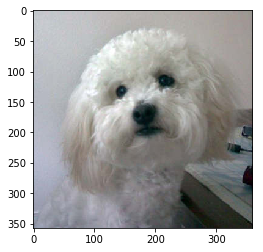

The predicted breed is...Giant schnauzer


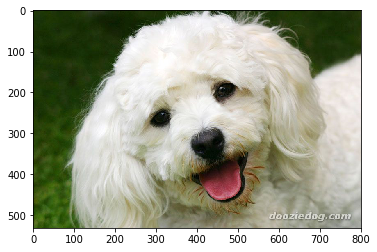

The predicted breed is...Cavalier king charles spaniel


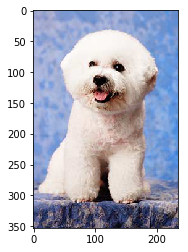

The predicted breed is...American eskimo dog


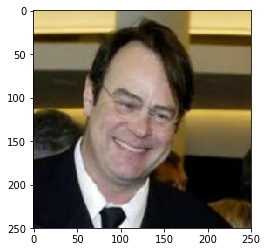

Hello human!  You most closely resemble a ... German pinscher


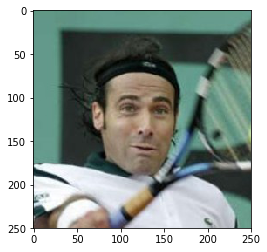

Hello human!  You most closely resemble a ... German pinscher


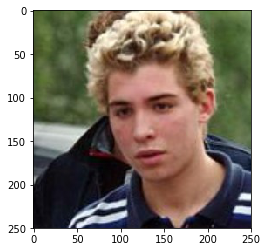

Hello human!  You most closely resemble a ... German pinscher


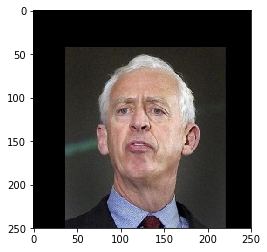

Hello human!  You most closely resemble a ... German pinscher


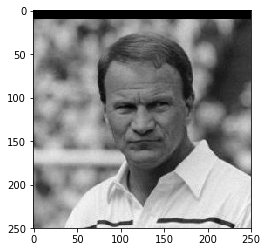

Hello human!  You most closely resemble a ... German pinscher


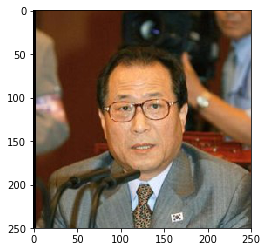

Hello human!  You most closely resemble a ... German pinscher


In [38]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

for file in test_images[27:35]:
    run_app(file)
for file in human_files[:6]:
    run_app(file)